# Assignment 3 Intro to Data Science: Clustering 

For this data analysis I am gonna use the same Wildfires dataset as in assignment 2. The data maps the amount of burned land in the US and the cost of reperation and is downloaded from: https://www.kaggle.com/datasets/kkhandekar/total-wildfires-acres-affected-1983-2020. 
I am gonna do the same data inspection, data wrangling as before and then use the Gaussian Mixure Models clustering algorithm to create clusters out of the data. 

In [ ]:
pip install jinja2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import random, os, sys, shutil
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import jinja2
import matplotlib.pyplot as plt
%matplotlib inline
#Dont use scientific notation for numbers (e.g 1.003767687e-12)
pd.set_option('display.float_format','{:.2f}'.format)   # DETTE HANDLER OM HVORDAN DET VISES! 
np.set_printoptions(suppress=True)

In [5]:
# load in data
df = pd.read_csv('Wildfires.csv')

In [6]:
# lets look at the data
print(df.columns)
# check available data
print(df.isna().any())
print(df.shape)

Index(['Year', 'Fires', 'Acres', 'ForestService', 'DOIAgencies', 'Total'], dtype='object')
Year             False
Fires            False
Acres            False
ForestService    False
DOIAgencies      False
Total            False
dtype: bool
(36, 6)


The data has shape (36,6) meaning it has 6 columns with 36 rows each. 
None of the columns are missing any values. 

I am using reges and .replace() to onvert all the data to type float instead of strings - this makes it compatible with the matplotlib and sklearn libraries. 

In [7]:
# remove special characters 
df['Fires']=df.Fires.replace(',', '', regex=True)
df['Acres'] = df.Acres.replace(',','',regex=True)
df['Total'] = df.Total.replace(',','',regex=True)
df['Total'] = df.Total.str.replace('$','',regex=True)
df['ForestService'] = df.ForestService.str.replace(',','',regex=True)
df['ForestService'] = df.ForestService.str.replace('$','',regex=True)
df['DOIAgencies'] = df.DOIAgencies.replace(',','',regex=True)
df['DOIAgencies'] = df.DOIAgencies.str.replace('$','',regex=True)

# convert to float 
df['Fires'] = df['Fires'].astype(float)
df['Acres'] = df['Acres'].astype(float)
df['ForestService'] = df['ForestService'].astype(float)
df['Total'] = df['Total'].astype(float)
df['DOIAgencies'] = df['DOIAgencies'].astype(float)

# Data wrangling 

In [8]:
# display the data with different forms of decimals without changing the data 
pd.options.display.float_format = '{:,.2f}'.format 
df.describe()

,Year,Fires,Acres,ForestService,DOIAgencies,Total
count,36.00,36.00,36.00,36.00,36.00,36.00
mean,"2,002.50","73,118.69","5,445,069.72","865,816,638.89","267,363,138.89","1,133,179,777.78"
std,10.54,"12,723.25","2,841,679.84","636,855,540.69","149,919,541.42","777,180,717.26"
min,"1,985.00","47,579.00","1,329,704.00","111,625,000.00","56,436,000.00","202,778,000.00"
25%,"1,993.75","66,012.25","2,939,220.25","325,454,000.00","135,720,500.00","462,020,500.00"
50%,"2,002.50","72,360.50","4,836,827.00","714,055,500.00","275,409,000.00","936,612,500.00"
75%,"2,011.25","82,323.25","8,245,757.25","1,216,716,250.00","396,079,750.00","1,633,618,750.00"
max,"2,020.00","96,385.00","10,125,149.00","2,615,256,000.00","528,000,000.00","3,143,256,000.00"


I am gonna use the df.corr() function from pandas to get an overview over any correlations that might be. 

Variables that I am interested in: 

Year and Total: 
- This is interesting. We know from our linear regression from assignment 2 that the amount of acres burned is positively correlated with the total cost. Therefore the correlation number 0.86 indicates that the amount of acres burned is more or less the same each year. 

Fires and Total: 
- We also know from assignment 2 that there is no linear correlation between the number of fires and the total cost, which is confirmed to be the number is -0.27 indicating a very little chance of a correlation and in any case not a positive one



In [13]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

<ipython-input-13-f0f86bb9996e>:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,Year,Fires,Acres,ForestService,DOIAgencies,Total
Year,1.00,-0.35,0.64,0.84,0.87,0.86
Fires,-0.35,1.00,0.04,-0.27,-0.27,-0.27
Acres,0.64,0.04,1.00,0.73,0.80,0.75
ForestService,0.84,-0.27,0.73,1.00,0.92,1.00
DOIAgencies,0.87,-0.27,0.80,0.92,1.00,0.95
Total,0.86,-0.27,0.75,1.00,0.95,1.00


# Clustering with K-means 
I am gonna try to cluster the data with k-means to see if there is any useful patterns. 
As k-means clustering is used for unsupervised data - without labels - and is a form for hard clustering, I am gonna try to do this first a couple of times and then use the Gaussian Mixture Model to cluster afterwards and compare the two models. 

Most of the code in this section is taken from the notebook, 'Week-6-Clustering-With-K-Means.ipynb' from the Intro to Data Science course. 

In [18]:
# standardise - especially the column, duration to be just minutes 
x = df 
x_scaled = StandardScaler().fit_transform(df)

#Get reduced dimensions
pca = PCA(n_components=2)
x_2d = pca.fit_transform(x_scaled)

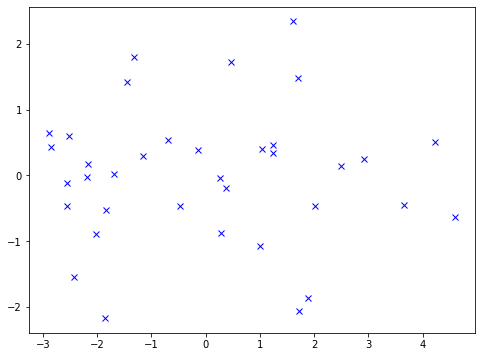

In [19]:
# plot the data
plt.figure(figsize=(8, 6))
a = plt.plot(x_2d[:,0],x_2d[:,1],"bx")

Our data is quite spread out and doesn't initially show any clear clusters - this could indicate that the k-mean might not be the best method for this data as it is very sensitive to outliers. So even though spread out data doesn't necessarily indicate outliers, the few data poitns could impact the sensitive k-mean clustering method. 

We are gonna define a few functions that is needed for the clustering 

In [21]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='r', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_clusters(clusterer, X):
    labels = clusterer.predict(X)
    pca = PCA(n_components=2)  
    x_2d = pca.fit_transform(X)
    plt.scatter(x_2d[:, 0], x_2d[:, 1], c=labels, alpha=0.3)
    plot_centroids(clusterer.cluster_centers_)

The elbow plot is used to get an indicating of the best value of k (the number of clusters) and I am therefore going to plot this first. 

This algorithm plots the inertia as a function of k (the number of clusters). 

The inertia is the distance from each datapoint to each centroid and is calculated after every time the k-means algorithm runs with a new number of k. 

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

AttributeError: ignored

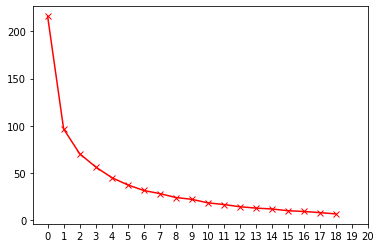

In [22]:
# plot the elbow plot 
scores=[]
for i in range(1,20):
    #Fit for k
    means=KMeans(n_clusters=i)
    means.fit(x_scaled)
    #Get inertia
    scores.append(means.inertia_)
plt.plot(scores,"-rx")
plt.xticks(np.arange(0, 21, 1.0))
plt.x



I would say that the elbow in this case is located at the cluster 4 or 5, so that is what I will write to the variable, k

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


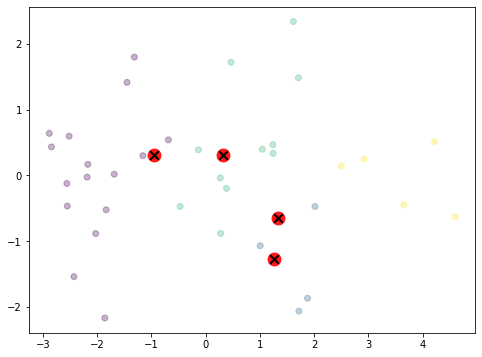

In [23]:
# clustering based on all the features | number of clusters: 4
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(x_scaled)
plt.figure(figsize=(8,6))
#Plot clusters onto PCA reduced plot
plot_clusters(kmeans, x_scaled)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


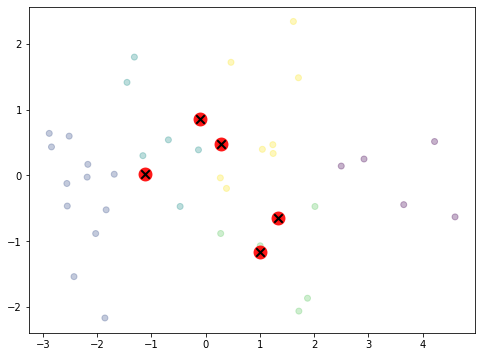

In [24]:
# clustering based on all the features | number of clusters: 5
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(x_scaled)
plt.figure(figsize=(8,6))
#Plot clusters onto PCA reduced plot
plot_clusters(kmeans, x_scaled)

So we get two kind of similar outputs. 
The clustering with 4 clusters seems to be better than with 5, even though it also doesn't seem perfect. The centroid of the purple and yellow cluster seems to be very far from any datapoints in the 4 cluster output. We have the same problem in the output with 5 clusters. 

Will reduce the dimensions so we are only plotting in 2D 

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


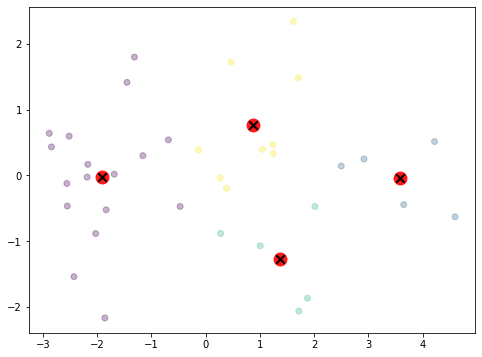

In [26]:
# clustering with reduced dimensions 

#How many dimensions to reduce to (before clustering)?
num_dimensions = 2 

#Reduce dimensions
pca = PCA(n_components=num_dimensions)
x_less_dimensions = pca.fit_transform(x_scaled)

#Fit cluster
kmeans = KMeans(n_clusters=4, random_state=20)
kmeans.fit(x_less_dimensions)

#Plot results on 2D plot
plt.figure(figsize=(8, 6))
plot_clusters(kmeans, x_less_dimensions)

The clustering with the reduced dimensions are generating a way better result than the clustering with the non-reduced dimensions. 
The centroids seems to be placed in the center of the datapoints of each cluster and there is less 'incisions' of one cluster to another. 

However, the clusters do look quite similar, the biggest difference being the placement of the centroids.

without reduced: 

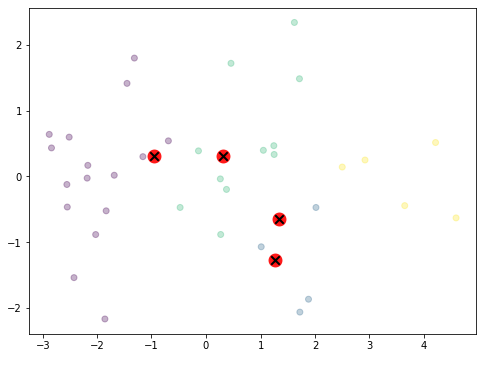

with reduced:

 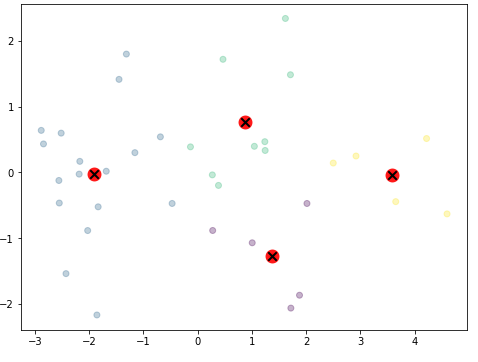


I'm gonna run the algoritm a few more times and see what happens to the output. 




Runs with 5 clusters 

1st run: 

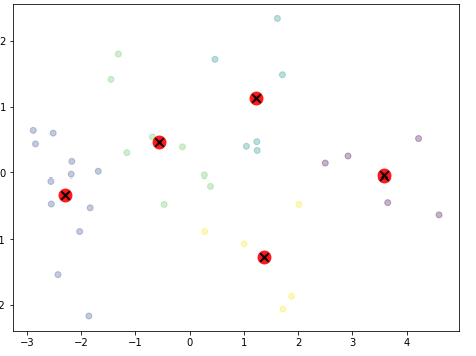

2nd run: 

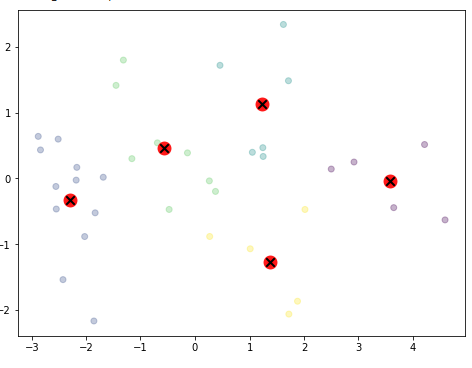

3rd run: 

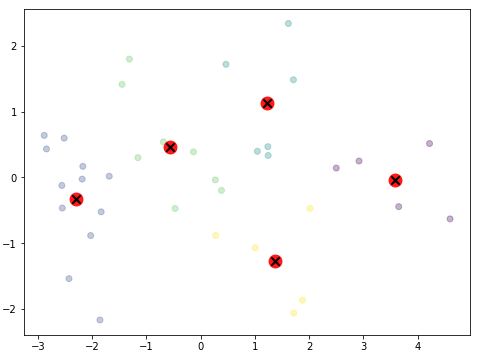


Runs with 4 clusters 

1st run: 

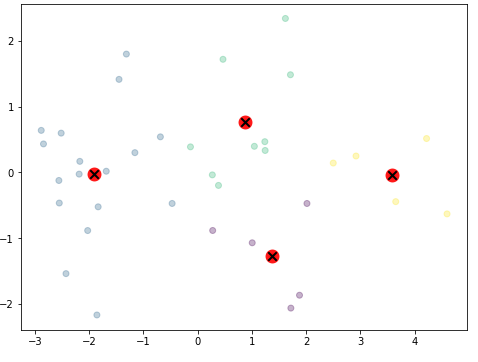

2nd run: 

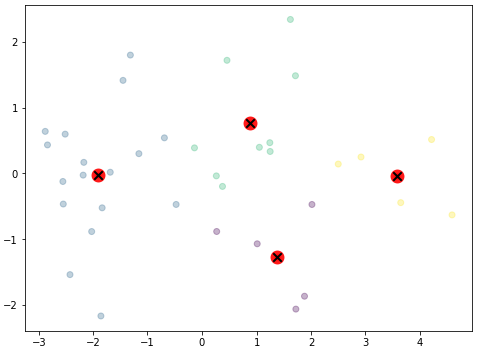


3rd run: 

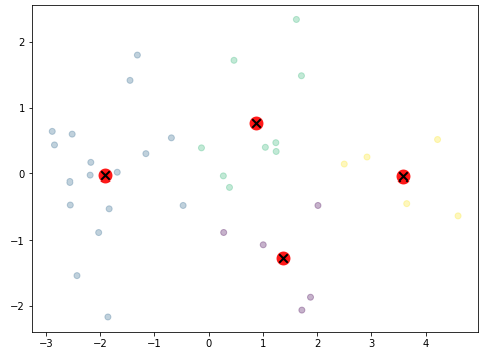

Running the algorithm more times doesn't show any difference indicating that the centroids are so close together that the clustering is good. 

I am gonna try to change the random_state parameter to pass in another seed. The number of seeds influencing how the centroids are being instantialized. 

###Results for clustering with different number of seeds. 

random_state = 80


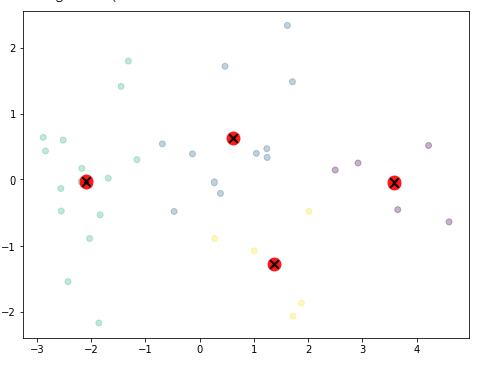


random_state = 20


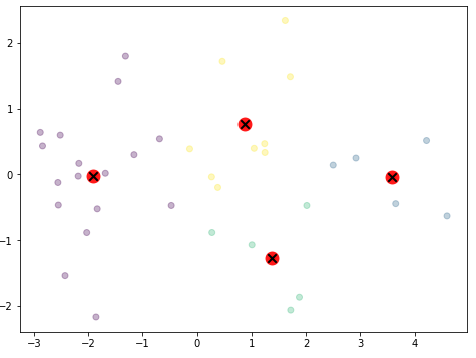

This does make some difference with some data points shifting cluster. 

To understand the results better, I am gonna plot the features of each cluster, the features being the mean values of each column. 


<ipython-input-27-6eaf004930e1>:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('cool')


Text(0.5, 0, 'cluster number')

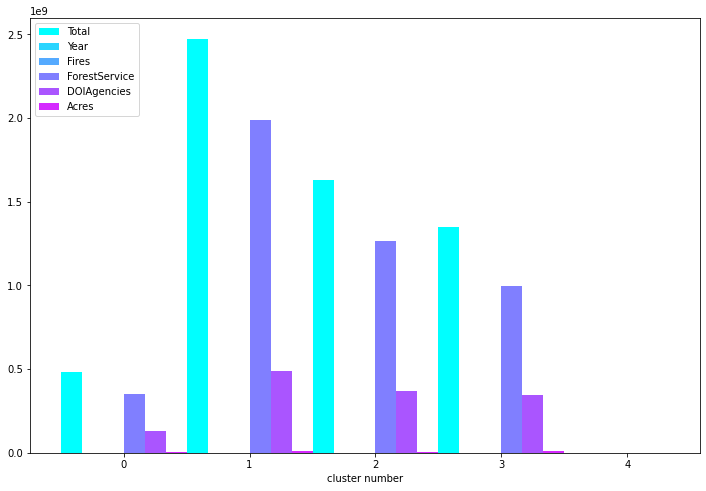

In [27]:
#Add cluster labels as extra column in dataframe
labels = kmeans.predict(x_less_dimensions)
x["cluster"] = labels

#Pick some features to plot
features = ['Total','Year','Fires','ForestService','DOIAgencies','Acres']
width = 1/(len(features))

fig,ax = plt.subplots(figsize=(12, 8))

for i in range(k):
    ax.bar([i],[1],width=width*4,color = "azure" if i%2==0 else "whitesmoke")

cmap = plt.cm.get_cmap('cool')
#Iterate through features
for index, f in enumerate(features):
    #Get mean for each feature for each cluster
    data = [np.mean(x[x["cluster"]==i][f]) for i in range(k)]
    
    x_vals = np.arange(len(data)) + (width*index) - 0.5 + width/2
    
    #Plot this feature for each cluster
    ax.bar(x_vals, data, width = width, label = f, color = cmap(index/len(features)))
    
ax.legend()
ax.set_xlabel("cluster number")

This shows that the distribution of the different columns are very different for each cluster and some of the columns being completely or nearly absent in some of the clusters - interestingly enough these mainly features being Year, Acres and Fires. 

We have already checked that none of the columns are missing data so that's not the cause of the absence. 

This plot is telling how each cluster is being 'made' - meaning what distinguishes one cluster from another. This means that the absent features either have been very similar in their distribution across the datapoints - meaning that the values of this column is consistent across the data. This explanation would make sense for the Acres feature, as we know - again from assignment 2 - that this variable is strongly correlated to the Total cost, and also (I would assume) the ForestService and the DOIAgencies features. 

This explanation also makes sense for the absent feature, Year as we know that the data shape is (36,6) and therefore the variation in the values would be in a range of 36 and therefore small enough to not really have an impact on the clusters. For the feature, Fires we know - from assignment 2 - that there is no correlation between Fires and the Total cost, and therefore (if the assumption that a correlation between Total also means a correlation between ForestService and the DOIAgencies) that some of the Fires have been very costly and therefore that it is varying a lot across the dataset and therefore not insignificant when making the clusters. 

The first cluster is also interesting as it only contains the feature 'Total' indicating that the values is significant different than the values in the other columns. 

In order to understand the result of this clustering method, I am gonna calculate the The Davies-Bouldin Index that is one way to understand how good a clustering method is for a given dataset. 

In [28]:
from sklearn.metrics import davies_bouldin_score

score = davies_bouldin_score(x, labels)

print("Davies-Bouldin index:", score)

Davies-Bouldin index: 1.1542450080014424


The Davies-Buoldin index for the k-means clustering method is 0.8693514326857206

# Clustering with Gaussian Mixture Model

Lets compare the k-means clustering with the Gaussian Mixture Model. 

In this method the best value of k is calculated by calculating the Bayesian Information Criterion Score (BIC score). 


In [ ]:
def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)


param_grid = {
    "n_components": range(1, 7),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(x_scaled)

GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['spherical', 'tied', 'diag',
                                             'full'],
                         'n_components': range(1, 7)},
             scoring=<function gmm_bic_score at 0x7f4191337a60>)

In [ ]:
bic_scores = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
bic_scores["mean_test_score"] = -bic_scores["mean_test_score"]
bic_scores = bic_scores.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
bic_score = bic_scores.sort_values(by="BIC score").head()
print(bic_score)

   Number of components Type of covariance  BIC score
18                    1               full     128.89
6                     1               tied     128.89
7                     2               tied     150.75
8                     3               tied     176.23
0                     1          spherical     183.92


The best value of k is the one that corresponds to the lowest BIC score, which in this case can be both 18 and 6. 

In this case where there is so few datapoints it seems overkill with 18 clusters, so I am gonna set k = 6. 

In [ ]:
# the lowest bic score is the best value of k 
k = bic_score.iloc[0,0]    # this sets k to 1 why we only get one cluster 
cov_type = bic_score.iloc[0,1]

In [ ]:
# make the clusters
def plot_clusters(clusterer, X):
    labels = clusterer.predict(X)
    pca = PCA(n_components=2)
    x_2d = pca.fit_transform(X)
    plt.scatter(x_2d[:, 0], x_2d[:, 1], c=labels, alpha=0.3)

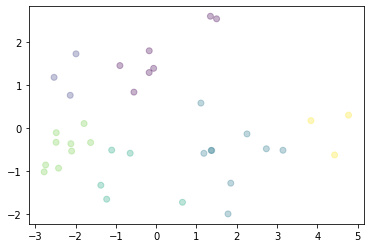

In [ ]:
gmm = GaussianMixture(n_components=6, covariance_type=cov_type, random_state=80)
gmm = gmm.fit(x_scaled)
plot_clusters(gmm, x_scaled)

This clustering seems okay even though there is some data points that are far of what could be the center of it's cluster. There is also some datapoints that are placed nearly in the same place in the space, but still belongs to each their cluster. 

I am gonna try to reduce the dimensions and see if this makes a big difference. 

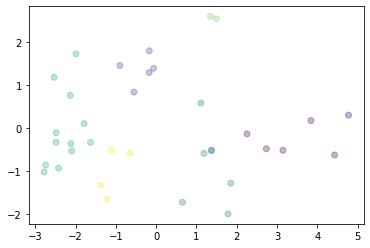

In [ ]:
#How many dimensions to reduce to (before clustering)?
num_dimensions = 2 

#Reduce dimensions
pca = PCA(n_components=num_dimensions)
x_less_dimensions = pca.fit_transform(x_scaled)

gmm = GaussianMixture(n_components=6, covariance_type='diag', random_state=20)
gmm = gmm.fit(x_less_dimensions)
plot_clusters(gmm, x_less_dimensions)

With reduced dimensions, the clusters look completely different and much more reliable. I am gonna run the algorithm a few times with different seeds. 


1st run, 42 seeds 

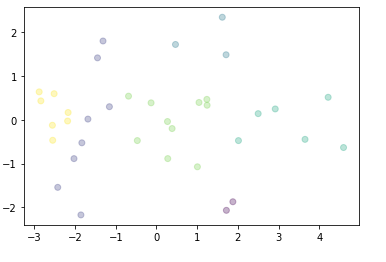


2nd run, 42 seeds 

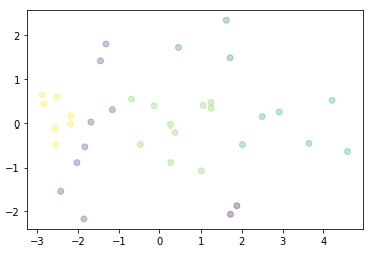

1st run, 80 seeds 

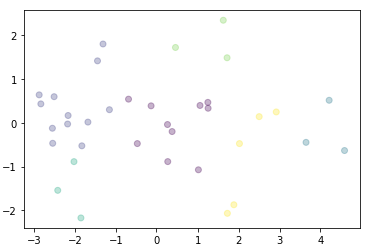

2nd run, 80 seeds 

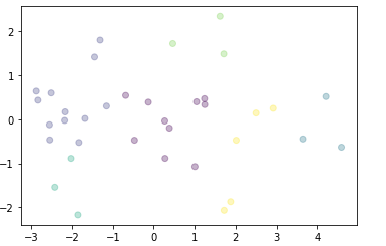


1st run, 20 seeds 

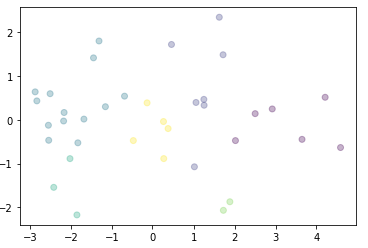

And then I am gonna have a look at the features for each cluster, using the same method as before. 

Text(0.5, 0, 'cluster number')

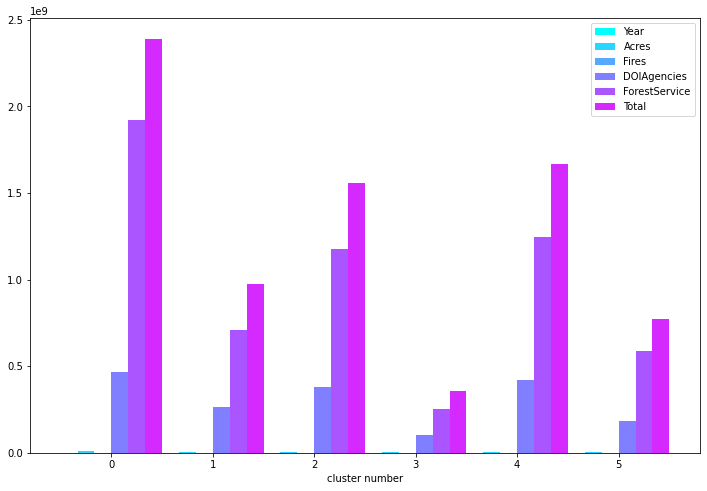

In [ ]:
#Add cluster labels as extra column in dataframe
labels = gmm.predict(x_less_dimensions)
x["cluster"] = labels

#Pick some features to plot
features = ['Year', 'Acres', 'Fires', 'DOIAgencies','ForestService','Total']
width = 1/(len(features))

fig,ax = plt.subplots(figsize=(12, 8))

for i in range(k):
    ax.bar([i],[1],width=width*4,color = "azure" if i%2==0 else "whitesmoke")

cmap = plt.cm.get_cmap('cool')
#Iterate through features
for index, f in enumerate(features):
    #Get mean for each feature for each cluster
    data = [np.mean(x[x["cluster"]==i][f]) for i in range(6)]
    
    x_vals = np.arange(len(data)) + (width*index) - 0.5 + width/2
    
    #Plot this feature for each cluster
    ax.bar(x_vals, data, width = width, label = f, color = cmap(index/len(features)))
    
ax.legend()
ax.set_xlabel("cluster number")

The distribution of the features of the clsuters are very similar to the one we got with the k-means clustering method. 
The year has more to say here, but is almost completely absent, while the Total is one of the biggest influencers of the clusters, not having it's own though. 


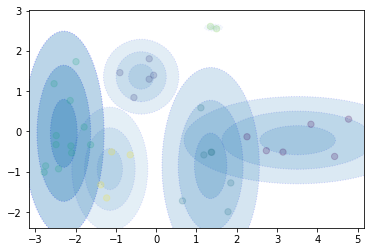

In [ ]:
# plot density around each cluster 
from matplotlib.patches import Ellipse

# Code for visualising GMM's from: https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle,  edgecolor='blue', linestyle=':', **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2, alpha=0.2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2, alpha=0.2)
    ax.axis('equal')
    
    w_factor = 0.3 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

plot_gmm(gmm, x_less_dimensions)

In [ ]:
from sklearn.metrics import davies_bouldin_score

score = davies_bouldin_score(x, labels)

print("Davies-Bouldin index:", score)

Davies-Bouldin index: 1.4368417305077463


The Davies-Bouldin Index for the Gaussian Mixture Model clustering method is 1.4368417305077463

The lower the value the better is the clustering, in this case meaning that the k-means clustering seems to be the best method for the WildFires dataset. 

